# **Lung-PET-CT-Dx | A Large-Scale CT and PET/CT Dataset**

In [1]:
import kagglehub
path = kagglehub.dataset_download("abdullahikabiru/lung-pet-ct-dx")
path

100%|██████████| 968M/968M [00:51<00:00, 19.7MB/s]

Extracting files...


'/root/.cache/kagglehub/datasets/abdullahikabiru/lung-pet-ct-dx/versions/1'

In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
import itertools
import warnings
warnings.filterwarnings("ignore",category=FutureWarning)
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix
import cv2
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

# **Loading DataSet**

In [3]:
image_files = []
for root, _, files in os.walk('/root/.cache/kagglehub/datasets/abdullahikabiru/lung-pet-ct-dx/versions/1'):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')):
            image_files.append(os.path.join(root, file))

def extract_class_name(filepath):
    class_name = filepath.split("/")[-2]
    return class_name

In [4]:
image_files = random.sample(image_files, len(image_files))
num_images = len(image_files)

# working with half of the images
midpoint = len(image_files) // 2
half_image_files = image_files[:midpoint]
image_data = np.zeros((midpoint, 224, 224, 3), dtype=np.uint8)
class_labels = []

for i, image_file in enumerate(half_image_files):
    try:
        image = cv2.imread(image_file)
        image = cv2.resize(image, (224, 224))
        image_data[i] = image
        class_labels.append(extract_class_name(image_file))
    except Exception as e:
        print(f"Error loading image {image_file}: {e}")

image_data.shape

(6747, 224, 224, 3)

In [5]:
class_labels = np.array(class_labels)

# **Preprocessing**

In [6]:
def histogram_equalization(image):
    # Histogram equalization
    equalized_image = cv2.equalizeHist(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
    equalized_image = cv2.cvtColor(equalized_image, cv2.COLOR_GRAY2BGR)  # Convert back to BGR
    return equalized_image


enhanced_images = []
for image in image_data:
    enhanced_image = histogram_equalization(image)
    enhanced_images.append(enhanced_image)

image_data = np.array(enhanced_images)

In [7]:
# One-hot encode the class labels
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
class_labels = lb.fit_transform(class_labels)

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(image_data, class_labels, test_size=0.15, random_state=42)


# Create data generators

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
validation_generator = val_datagen.flow(X_val, y_val, batch_size=32)

In [8]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((5734, 224, 224, 3), (5734, 3), (1013, 224, 224, 3), (1013, 3))

# **Class weights**

In [9]:
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique(np.argmax(y_train, axis=1)),
                                                 y=np.argmax(y_train, axis=1))
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.4414164742109315, 1: 6.328918322295806, 2: 1.734422262552934}

# **Data Visualization**

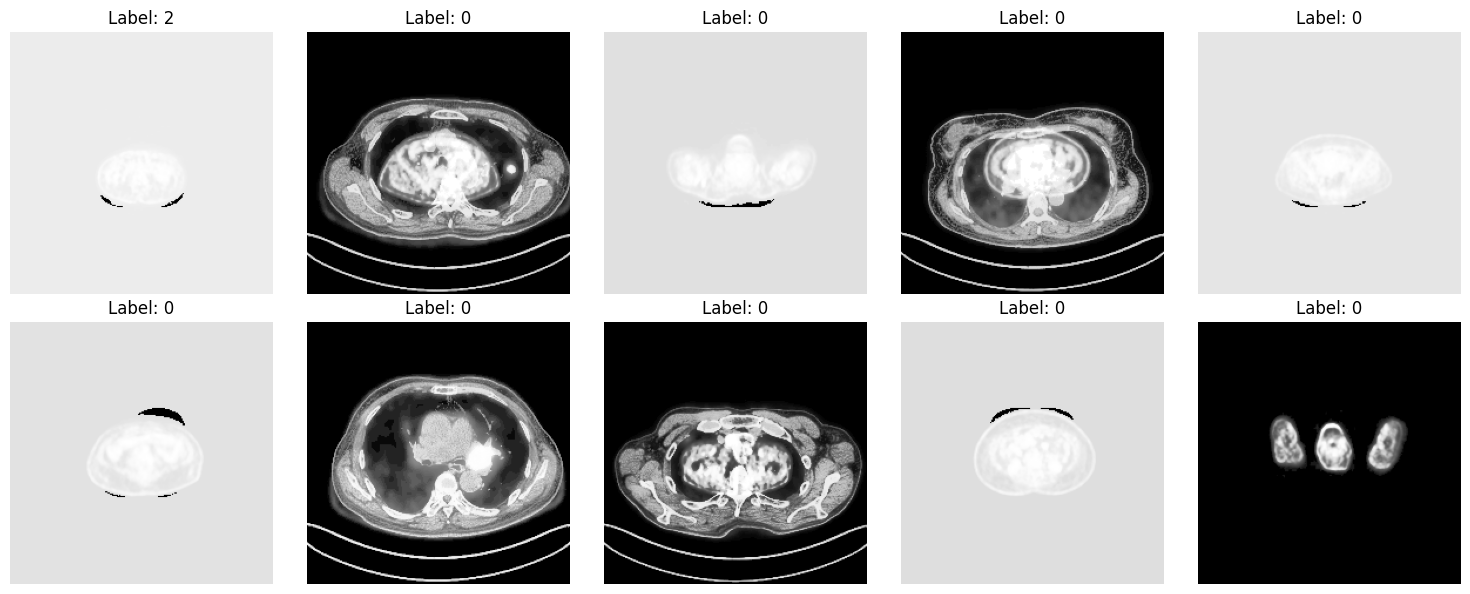

In [10]:
images, labels = next(train_generator)

# Display the images with their labels
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i in range(10):
    axes[i].imshow(images[i])
    axes[i].set_title(f"Label: {np.argmax(labels[i])}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

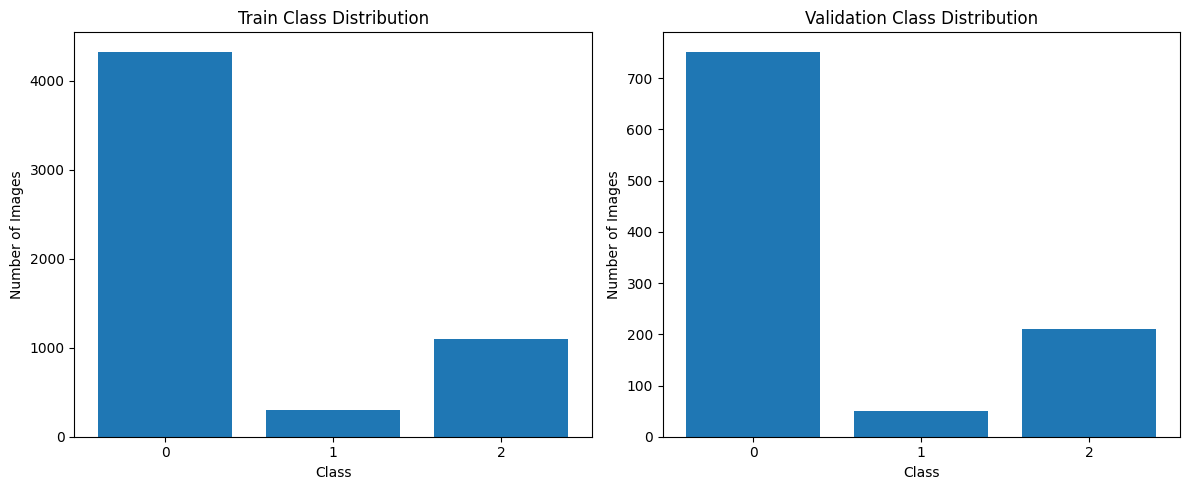

In [11]:
def plot_class_distribution(generator, title):
    class_counts = {}
    for i in range(len(generator)):
        _, labels = next(generator)
        for label in labels:
            class_index = np.argmax(label)
            class_counts[class_index] = class_counts.get(class_index, 0) + 1

    classes = sorted(class_counts.keys())
    counts = [class_counts[cls] for cls in classes]

    plt.bar(classes, counts)
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.title(title)
    plt.xticks(classes)


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plot_class_distribution(train_generator, "Train Class Distribution")

plt.subplot(1, 2, 2)
plot_class_distribution(validation_generator, "Validation Class Distribution")


plt.tight_layout()
plt.show()

# **Model Training**

In [12]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers[-30:]:
    layer.trainable = True

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 26,212,227 (99.99 MB)

 Trainable params: 26,159,107 (99.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [14]:
# optimizer = Adam(learning_rate=0.001)
# model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

optimizer = RMSprop(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [15]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs= 50,
    callbacks=[early_stopping]
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


180/180 ━━━━━━━━━━━━━━━━━━━━ 136s 465ms/step - accuracy: 0.6994 - loss: 26.4011 - val_accuracy: 0.7423 - val_loss: 235102.9375
Epoch 2/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 52s 287ms/step - accuracy: 0.7569 - loss: 0.7561 - val_accuracy: 0.7423 - val_loss: 0.7209
Epoch 3/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 52s 286ms/step - accuracy: 0.7624 - loss: 0.6835 - val_accuracy: 0.7423 - val_loss: 0.7018
Epoch 4/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 52s 287ms/step - accuracy: 0.7540 - loss: 0.6929 - val_accuracy: 0.7423 - val_loss: 1.2586
Epoch 5/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 54s 302ms/step - accuracy: 0.7587 - loss: 0.6940 - val_accuracy: 0.7423 - val_loss: 0.7271
Epoch 6/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 52s 289ms/step - accuracy: 0.7544 - loss: 0.6899 - val_accuracy: 0.7423 - val_loss: 0.6987
Epoch 7/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 52s 288ms/step - accuracy: 0.7510 - loss: 0.6939 - val_accuracy: 0.7423 - val_loss: 0.6945
Epoch 8/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 52s 288ms/step - accuracy: 0.7557 - loss: 0.691

# **Model Evaluation**

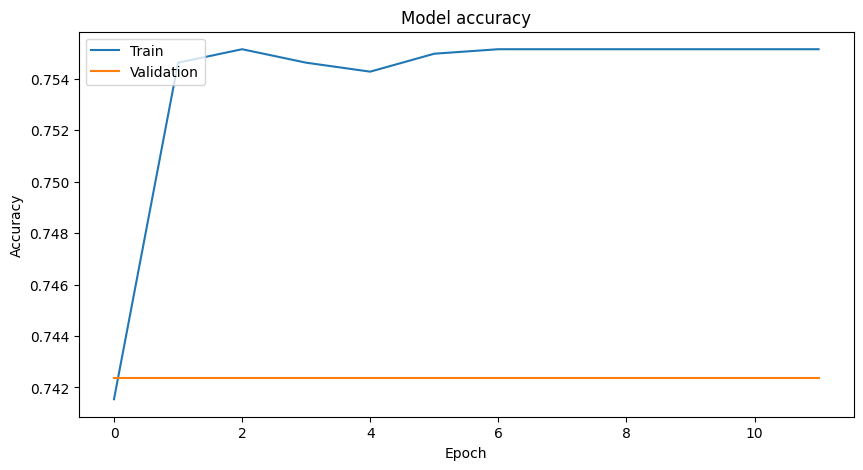

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()